In [1]:
import numpy as np
from utils import myfwht, run_many
import matplotlib.pyplot as plt

- Polynomial has few non-zero coefficients (understood, and utilized)
- Each monomial in the polynomial has few variables (low degree)
  - Noisy:
      - O(nnK) samples (we are here)
      - O(dnK) samples
      - O(nK) samples

In [2]:
class InputSignal:
    def __init__(self, n, loc, val=None, noise_std=0):
        self.n = n
        self.loc = loc
        if val is None:
            self.val = np.ones_like(self.loc)
        else:
            self.val = val
        self.noise_std = noise_std
        
        self.x_wht = None
        self.x_time = None
        
    def make_signal(self):
        N = 2**n
        x_wht    = np.zeros(N)
        for i,k in enumerate(self.loc):
            x_wht[k] = self.val[i]
            
        x_time = myfwht(x_wht)
        
        if self.noise_std != 0:
            x_time += self.noise_std*np.random.randn(len(x_time))
        
        self.x_wht = myfwht(x_time)/N
        self.x_time = x_time
        
    def __getitem__(self, index):
        if self.x_time is not None:
            return self.x_time[index]
        else:
            return None
        
def get_random_sparse_binary_vector(n, k):
    u = np.zeros(n, dtype=np.bool)
    bit_indices = np.random.choice(n,k)
    u[bit_indices] = 1
    return u

def get_random_binary_vector(n, p=0.5):
    a = np.random.binomial(1,p,size=n)
    return a

def get_random_binary_matrix(m, n, p=0.5):
    A = np.random.binomial(1,p,size=(m,n))
    return A

def dec_to_bin(x, num_bits):
    assert x < 2**num_bits, "number of bits are not enough"
    u = bin(x)[2:].zfill(num_bits)
    u = list(u)
    u = [int(i) for i in u]
    return np.array(u)

def bin_to_dec(x):
    n = len(x)
    c = 2**(np.arange(n)[::-1])
    return c.dot(x)

def get_sampling_index(x, A, p=0):
    """
    x: sampling index
    A: subsampling matrix
    p: delay
    """
    num_bits = A.shape[0]
    x = dec_to_bin(x, num_bits)
    r = x.dot(A) + p
    return r % 2

def random_delay_pair(num_bits, p):
    random_seed = get_random_binary_vector(num_bits)
    
    return random_seed, (random_seed+p)%2

def make_delay_pairs(num_pairs, num_bits):
    z = []
    # this is the all zeros for finding the sign
    # actually we do not need this here because we solve
    # a linear system to find the value of the coefficient
    # after the location is found -- however, i am going to
    # keep this here not to have to change the rest of the code
    # that takes delays of this form
    z.append(dec_to_bin(0,num_bits))
    # go over recovering each bit, we need to recover bits 0 to num_bits-1
    for bit_index in range(0, num_bits):
        # we have num_pairs many pairs to do majority decoding
        for pair_idx in range(num_pairs):
            a,b = random_delay_pair(num_bits, bit_index)
            z.append(a)
            z.append(b)
    return z

def get_random_measurement_pair(input_signal, n, u):
    p0, p1 = random_delay_pair(n, u)
    
    k0 = bin_to_dec(p0)
    k1 = bin_to_dec(p1)
    
    y0 = input_signal[k0]
    y1 = input_signal[k1]
    
    return y0, y1

In [3]:
# number of variables
n = 16

# true location
true_location = 2**(n-4)
locations = np.array([true_location])

b_true_location = dec_to_bin(true_location, n)
print('true location: {}'.format(true_location))
print('bit true location: {}'.format(b_true_location))

true location: 4096
bit true location: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


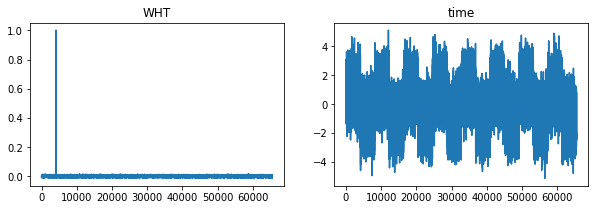

In [4]:
# make signal and plot it
input_signal = InputSignal(n, locations, noise_std=1)
input_signal.make_signal()

fig, axs = plt.subplots(1,2, figsize=(10,3))

axs[0].plot(input_signal.x_wht)
axs[0].set_title('WHT')

axs[1].plot(input_signal.x_time)
axs[1].set_title('time')
plt.show()

In [5]:
input_signal.x_wht

array([-0.0030334 , -0.01125188,  0.00329924, ...,  0.00467275,
       -0.00012146,  0.00221273])

In [6]:
# n=23, d=3, num rows=11 = Golay Codes

In [7]:
# encoding matrix
H = list(map(lambda x:dec_to_bin(x,4), np.arange(n)))
H = np.vstack(H).T
print('encoding matrix:')
print(H)

true_syndrome = H.dot(b_true_location)
print('true syndrome of the location:')
print(true_syndrome)

encoding matrix:
[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1]
 [0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]]
true syndrome of the location:
[0 0 1 1]


In [8]:
np.eye(n, dtype=np.int)

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [9]:
# u: true location
# r: random location
# v: a chosen shift
# x[n] = (-1)^<u,n>
# y0: x[r] = (-1)^<u,r> + noise
# y1: x[r+v] = (-1)^<u,r+v> = x[r](-1)^<u,v> + noise
# x[r+v]/x[r] = (-1)^<u,v> 
bit_index_to_estimate = 0

print('true bit: {}'.format(true_syndrome[bit_index_to_estimate]))
print('----')

for i in range(10):
    y0, y1 = get_random_measurement_pair(input_signal, n, H[bit_index_to_estimate])
    print('y0: {0:.2f} \t y1: {1:.2f} \t bit_est(0+ and 1-): {2}'.format(y0, y1, y0*y1))
    

true bit: 0
----
y0: 0.38 	 y1: 0.27 	 bit_est(0+ and 1-): 0.10232248402094947
y0: -2.15 	 y1: -1.52 	 bit_est(0+ and 1-): 3.260557149350418
y0: -0.82 	 y1: -0.74 	 bit_est(0+ and 1-): 0.6092819036060407
y0: -0.31 	 y1: 0.79 	 bit_est(0+ and 1-): -0.24621978138814185
y0: -0.31 	 y1: 1.38 	 bit_est(0+ and 1-): -0.4221410994677761
y0: -0.43 	 y1: -1.57 	 bit_est(0+ and 1-): 0.6666848550055599
y0: 0.45 	 y1: 1.19 	 bit_est(0+ and 1-): 0.5410625145572425
y0: 0.75 	 y1: -0.81 	 bit_est(0+ and 1-): -0.605263469933303
y0: 0.24 	 y1: -2.68 	 bit_est(0+ and 1-): -0.6405173010113472
y0: -2.42 	 y1: -0.48 	 bit_est(0+ and 1-): 1.1630886007512937


In [10]:
def estimate_syndrome(input_signal, n, u, num_times):
    r = []
    for i in range(num_times):
        y0, y1 = get_random_measurement_pair(input_signal, n, u)
        r.append(np.sign(y0*y1))
    r = np.mean(r)
    return r

In [11]:
estimate_syndrome(input_signal, n, H[0], 1)

1.0

In [12]:
num_test = 10000
bit_index_to_estimate = 0
r = run_many(estimate_syndrome, 
             num_test, 
             input_signal=input_signal, 
             n=n, 
             u=H[bit_index_to_estimate], 
             num_times=11)

In [13]:
r = np.array(r)
r_bit = r < 0
error_indices = r_bit != true_syndrome[bit_index_to_estimate]
print('syndrome estimation error probability: {}%'.format(np.mean(error_indices)*100))

syndrome estimation error probability: 4.72%


In [14]:
num_times_vec = np.arange(1,15,2)
error_freq_vec = []
num_test = 10000
bit_index_to_estimate = 0

# go over different number of times
for num_times in num_times_vec:
    # run syndrome estimation simulations
    r = run_many(estimate_syndrome, 
                 num_test, 
                 input_signal=input_signal, 
                 n=n, 
                 u=H[bit_index_to_estimate], 
                 num_times=num_times)
    # calculate the error frequency
    r = np.array(r)
    r_bit = r < 0
    error_indices = r_bit != true_syndrome[bit_index_to_estimate]
    error_freq = np.mean(error_indices)
    error_freq_vec.append(error_freq)
error_freq_vec = np.array(error_freq_vec)
    

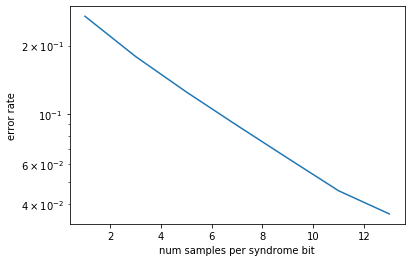

In [15]:
plt.semilogy(num_times_vec, error_freq_vec)
plt.xlabel('num samples per syndrome bit')
plt.ylabel('error rate')
plt.show()